In [5800]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.metrics import classification_report

In [5801]:
data_species = pd.read_csv('../Data/species.csv', index_col=0)

data = data_species.copy(deep=True)

In [5802]:
data.isna().sum()

site                              0
model                             0
Year                              0
Month                             0
Latitude                          0
Longitude                         0
Depth                             0
Region                            0
Coral_cover                     707
Reef_complexity                 707
SST                               0
NPP                               0
Wave_exposure                     0
Habitat_type_classLV0             0
Habitat_type_classLV2             0
Coral_area_UFRTM_20km             0
Coral_area_UFRTM_200km            0
Depth_Sbrocco                     0
Deepwater                         0
FSA                               0
Marina_slips_10km                 0
Marina_slips_25km                 0
Marine_reserve                    0
Population_20km                   0
Population_50km                   0
Recreational_fishermen_50km       0
Tourist_fishing                   0
Artificial_reefs_1km        

#### Remove Duplicates

In [5804]:
duplicates = ["REGION", "YEAR", "MAX_HARD_RELIEF", "PCT_CORAL", "Total_gravity_intercept"]

data = data.drop(duplicates, axis = 1)

#### Remove Features not related

In [5806]:
not_related = ["no.divers", "model", "Random", "site"]

data = data.drop(not_related, axis = 1)

#### Remove Features not relevant for the model

In [5808]:
#Most values are the same for Habitat_type_classLV0
print(data.Habitat_type_classLV0.value_counts())
print(data.Artificial_reefs_1km.value_counts().head(5))

# Majority of values are 0. Not very relevant.
not_for_model = ["Habitat_type_classLV0", "Artificial_reefs_1km"]

data = data.drop(not_for_model, axis = 1)


Habitat_type_classLV0
Coral Reef and Hardbottom    3988
Unconsolidated Sediment         7
Seagrass                        4
Name: count, dtype: int64
Artificial_reefs_1km
0    3430
1     221
2      84
3      39
5      36
Name: count, dtype: int64


In [5809]:
# Based on the ammount of Seagrass habitat above, we can remove Nursery_seagrass. The majority of values 0 
# of Nurse_seagrass may confirm that hunch

#Seagrass                        4
print(data.Nursery_seagrass.value_counts().head(5))


data = data.drop("Nursery_seagrass", axis = 1)

Nursery_seagrass
0.000000e+00    1050
4.366660e+07       3
4.334767e+04       3
4.563617e+07       3
1.316806e+06       3
Name: count, dtype: int64


In [5810]:
print(data.Nursery_mangroves.value_counts().head(5))

Nursery_mangroves
0.00000         768
183870.57810      3
20320.92969       3
294473.06250      3
204033.29690      3
Name: count, dtype: int64


## EDA

#### Zones and Regions analysis (Option 1)

##### Keeping only Keys_Divisions

In [5814]:
#Keys_Divisions

print(data.loc[data.Keys_Divisions.isna(),["Keys_Divisions", "Region"]])
print(data.loc[data.Keys_Divisions.isna(),["Keys_Divisions", "Region"]].Keys_Divisions.unique())
print(data.loc[data.Keys_Divisions.isna(),["Keys_Divisions", "Region"]].Region.unique())


#CONCLUSION: Kyes_Divisons and Region have the same information. The missing values of Keys_Divisions correspond to SEFCRI.

     Keys_Divisions  Region
1350            NaN  SEFCRI
1351            NaN  SEFCRI
1352            NaN  SEFCRI
1353            NaN  SEFCRI
1354            NaN  SEFCRI
...             ...     ...
3992            NaN  SEFCRI
3993            NaN  SEFCRI
3994            NaN  SEFCRI
3997            NaN  SEFCRI
3998            NaN  SEFCRI

[1429 rows x 2 columns]
[nan]
['SEFCRI']


In [5815]:
# Fill missing values with SEFCRI
data.fillna({'Keys_Divisions': 'SEFCRI'}, inplace=True)

#Checking results
data.groupby(["Keys_Divisions", "Region"]).mean(numeric_only=True).Diversity_index

#OBS: There is only one value that is labeled as Upper Key (from Keys_Division) and SEFCRI (from Region) 
#which migh be a mislabeled value according to the map bellow (The blue dot in the middle of FLA KEYS)

Keys_Divisions  Region  
Dry Tortugas    DRY TORT    0.800910
Lower Keys      FLA KEYS    0.839665
Marquesas       FLA KEYS    0.838233
Middle Keys     FLA KEYS    0.842083
SEFCRI          SEFCRI      0.826751
Upper Keys      FLA KEYS    0.851420
                SEFCRI      0.586588
Name: Diversity_index, dtype: float64

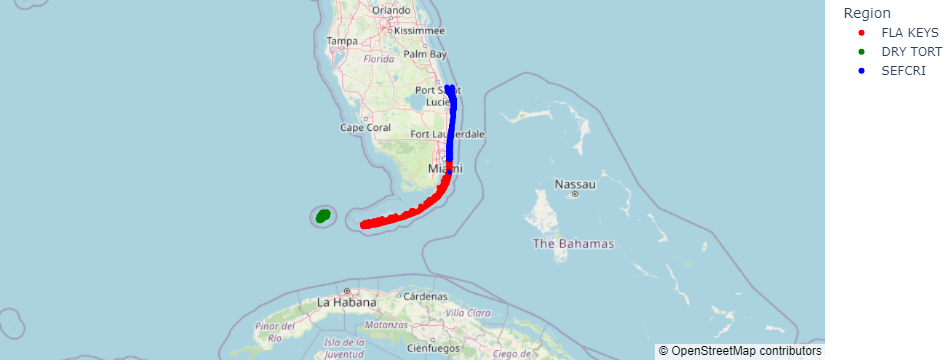

In [5816]:
fig = px.scatter_mapbox(data, lat="Latitude", lon="Longitude", hover_name = "Region", color="Region",
                        color_discrete_sequence=["Red", "Green", "Blue"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [5817]:
#BNP (part of FLA KEYS), FKNMS, CoralECA (aka SEFCRI), DryTortuga contain the same information combined in Keys_Divisions, so they can be dropped.

drop_individual_region = ["BNP", "FKNMS", "CoralECA", "DryTortugas"]

#data = data.drop(drop_individual_region, axis = 1)

#Drop the Region feature as well, since Keys_Divisions contains that information

#data = data.drop("Region", axis = 1)

#### Zones and Regions Analysis (Option 2)

##### Keep only combination of ["BNP", "FKNMS", "CoralECA", "DryTortugas"]

In [5820]:

# Define the column names
columns = ['BNP', 'DryTortugas', 'CoralECA', 'FKNMS']

# Combine the columns into one
data['Combined_sites'] = data[columns].apply(lambda row: row.dropna().iloc[0] if row.dropna().size > 0 else np.nan, axis=1)

# Drop the old columns
data.drop(columns, axis=1, inplace=True)
data.drop("Keys_Divisions", axis = 1, inplace=True)
data = data.drop("Region", axis = 1)
data.columns

Index(['Year', 'Month', 'Latitude', 'Longitude', 'Depth', 'Coral_cover',
       'Reef_complexity', 'SST', 'NPP', 'Wave_exposure',
       'Habitat_type_classLV2', 'Coral_area_UFRTM_20km',
       'Coral_area_UFRTM_200km', 'Depth_Sbrocco', 'Deepwater', 'FSA',
       'Marina_slips_10km', 'Marina_slips_25km', 'Marine_reserve',
       'Population_20km', 'Population_50km', 'Recreational_fishermen_50km',
       'Tourist_fishing', 'SG_permits_50km', 'SG_charter_permits_25km',
       'Total_gravity', 'Nursery_mangroves', 'connectivity', 'Comm_engagement',
       'Comm_reliance', 'Rec_engagement', 'Rec_reliance',
       'Commercial_pounds_landed', 'Pop_per_area_reef_20km', 'impact',
       'HABITAT_CD', 'Diversity_index', 'Combined_sites'],
      dtype='object')

### Anthropogenic stressors

#### impact

In [5823]:
print(data.corr(numeric_only=True).loc[:,["impact"]].sort_values(by = "impact", ascending = False, key = abs))

#CONLCUSION: The following features are highly related and maybe explainable only with the "impact" feature

# SST                            0.848783
# Recreational_fishermen_50km    0.832204
# Commercial_pounds_landed      -0.825649
# Marina_slips_25km              0.817805
# Population_50km                0.817650
# Population_20km                0.770920
# Tourist_fishing                0.741886

# ** Diversity_index **          0.142606


related_to_impact = ["SST", "Marina_slips_25km", 
                     "Population_20km", "Population_50km", "Recreational_fishermen_50km",
                    "Tourist_fishing", "Marina_slips_10km"]


data = data.drop(related_to_impact, axis = 1)

                               impact
impact                       1.000000
SST                          0.848783
Recreational_fishermen_50km  0.832204
Longitude                    0.829754
Commercial_pounds_landed    -0.825649
Marina_slips_25km            0.817805
Population_50km              0.817650
Population_20km              0.770920
Tourist_fishing              0.741886
Marina_slips_10km            0.690361
connectivity                 0.670892
NPP                         -0.663904
Pop_per_area_reef_20km       0.619547
Latitude                     0.592669
Deepwater                   -0.564464
SG_permits_50km              0.486797
FSA                         -0.462780
Total_gravity                0.389253
Coral_cover                 -0.283849
Reef_complexity             -0.212372
Year                         0.197741
SG_charter_permits_25km      0.184697
Depth_Sbrocco               -0.149393
Diversity_index              0.142606
Coral_area_UFRTM_200km      -0.140822
Nursery_mang

#### Marine_reserve

In [5825]:
data.groupby("Marine_reserve").mean(numeric_only=True).loc[:,["Diversity_index","Coral_cover","Reef_complexity"]]

#CONCLUSION: Protected areas have a higher Diversity_index, Coral_cover and Reef_compelxity. Therefore, a relevant feature to keep.

,Diversity_index,Coral_cover,Reef_complexity
Marine_reserve,,,
Closed,0.863205,4.646675,1.319098
Open,0.828011,4.536690,1.070473


#### Comm_reliance, Comm_engagement, Rec_reliance and Rec_engagement

In [5827]:
comm_rec = ["Comm_reliance", "Comm_engagement", "Rec_reliance", "Rec_engagement"]

data.corr(numeric_only = True).loc[:,comm_rec]

print(data[comm_rec].describe())

#Removing possible Outliers (?
data = data[data["Rec_reliance"] <= 12]

       Comm_reliance  Comm_engagement  Rec_reliance  Rec_engagement
count    3910.000000      3910.000000   3910.000000     3910.000000
mean       -0.069880         0.104939      0.424433        0.076328
std         0.139033         0.754119      2.247541        0.904179
min        -0.129000        -0.158000     -0.185000       -0.260000
25%        -0.129000        -0.158000     -0.185000       -0.260000
50%        -0.129000        -0.158000     -0.185000       -0.260000
75%        -0.118000        -0.105000      0.044000       -0.176000
max         0.347000         4.229000     12.140000        7.853000


### Other factors 

#### connectivity

Source: https://datadryad.org/stash/dataset/doi:10.5061/dryad.xpnvx0kmn
Information found on the README.md file

*According to the article:

"(connectivity): number of larva from upstream modeledto a connectivity matrix; model does not extend to further north reefs and those sites were assigned NAs". 


In [5831]:
#Since it's not possible to obtain the data, it is a strong candidate to be removed from final features, as trying to fill the
# NAs could be a problem in this case.

data = data.drop("connectivity", axis = 1)

#### Depth, Depth_Sbrocco, Deepwater

In [5833]:
feat = ["Depth", "Depth_Sbrocco", "Deepwater"]
print(data.corr(numeric_only = True).loc[["Diversity_index"], feat])

#Among the three features that are related to the depth, "Depth" is the one that 
#influences the most the Diversity_index and has less relation with the other features ( = less interdependency)

data = data.drop(["Deepwater", "Depth_Sbrocco"], axis = 1)

                    Depth  Depth_Sbrocco  Deepwater
Diversity_index -0.206994       0.120721  -0.033348


#### HABITAT_cd and Habitat_type_classLV2

In [ ]:
#TO-DO

#Check if they can be 

(The amount of carbon retained in an ecosystem)

In [5835]:
data.corr(numeric_only=True).NPP.sort_values(key=abs, ascending = False)

NPP                         1.000000
impact                     -0.699802
Latitude                   -0.645864
Commercial_pounds_landed    0.630467
Longitude                  -0.614163
Pop_per_area_reef_20km     -0.608108
Nursery_mangroves           0.414147
Coral_area_UFRTM_200km      0.410717
Coral_cover                 0.402221
Comm_reliance               0.358117
Total_gravity              -0.343117
Depth                      -0.333812
FSA                         0.325892
Rec_reliance                0.280689
Wave_exposure              -0.280596
SG_charter_permits_25km     0.274167
Year                       -0.268507
Comm_engagement             0.248272
Rec_engagement              0.238133
Coral_area_UFRTM_20km       0.195548
Reef_complexity             0.140714
Diversity_index            -0.061421
SG_permits_50km            -0.003768
Name: NPP, dtype: float64

#### Year and Month

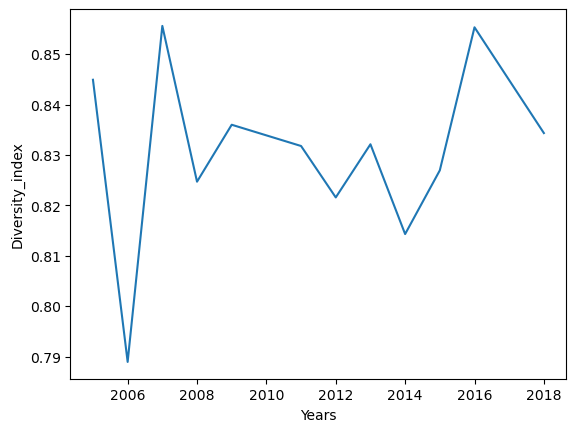

In [5837]:
years = data.groupby("Year").mean(numeric_only=True).index

plt.plot(years, data.groupby("Year").mean(numeric_only=True).Diversity_index)
plt.xlabel("Years")
plt.ylabel("Diversity_index")

#Conclusion: Different years does not seem to explain different Diversity_index
data = data.drop("Year", axis = 1)

(0.7, 0.9)

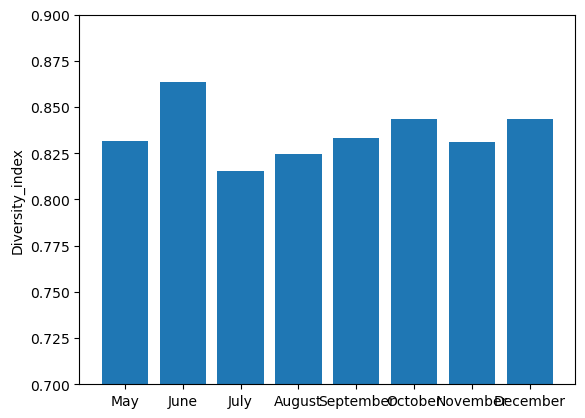

In [5838]:
month_order = ['May', 'June', 'July','August', 'September', 'October', 'November', 'December']

plt.bar(month_order, data.groupby("Month").mean(numeric_only=True).Diversity_index)
plt.ylabel("Diversity_index")
plt.ylim(0.7, 0.9)

#The change in Diversity_index could indicate summer/winter influence and special season for reproduction/fishing etc.

#### Remove Latitude and Longitude

In [5840]:
data = data.drop(["Latitude", "Longitude"], axis = 1)

#### Convert Categorical Data into Numeric

In [5842]:
# Convert categorical columns to numeric using label encoding
non_numeric_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [5843]:
data.columns

Index(['Month', 'Depth', 'Coral_cover', 'Reef_complexity', 'NPP',
       'Wave_exposure', 'Habitat_type_classLV2', 'Coral_area_UFRTM_20km',
       'Coral_area_UFRTM_200km', 'FSA', 'Marine_reserve', 'SG_permits_50km',
       'SG_charter_permits_25km', 'Total_gravity', 'Nursery_mangroves',
       'Comm_engagement', 'Comm_reliance', 'Rec_engagement', 'Rec_reliance',
       'Commercial_pounds_landed', 'Pop_per_area_reef_20km', 'impact',
       'HABITAT_CD', 'Diversity_index', 'Combined_sites'],
      dtype='object')

##### Features to be decided

In [5919]:
"SG_charter_permits_25km", 
"SG_permits_50km",
"Coral_area_UFRTM_20km", 
"FSA", 
"NPP",
"Wave_exposure",  
"Total_gravity",
"Habitat_type_classLV2",
"Coral_area_UFRTM_20km", 
"Coral_area_UFRTM_200km",
"Nursery_mangroves",
"HABITAT_CD"


data.isna().sum()

data.Habitat_type_classLV2.value_counts()

Habitat_type_classLV2
0    1256
3     531
6     528
2     504
7     367
4     293
1     230
5      78
Name: count, dtype: int64

#### EDA above not yet finished (!)

#### Fill Missing Values

In [5848]:
#Testing results removing the missing information of Coral_cover and Reef_complexity
#data = data[~data["Coral_cover"].isna()]
#data.isna().sum()

In [5849]:
#(This will probably give bad results) - For the Coral_cover maybe will be better 
#to remove the rows all together, since we cannot infer by the location


# Handle missing values: fill missing numeric values with the median
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())

In [5850]:
print("\n \n === Features Selected === \n\n")
print(data.columns)
print(data.count())


 
 === Features Selected === 


Index(['Month', 'Depth', 'Coral_cover', 'Reef_complexity', 'NPP',
       'Wave_exposure', 'Habitat_type_classLV2', 'Coral_area_UFRTM_20km',
       'Coral_area_UFRTM_200km', 'FSA', 'Marine_reserve', 'SG_permits_50km',
       'SG_charter_permits_25km', 'Total_gravity', 'Nursery_mangroves',
       'Comm_engagement', 'Comm_reliance', 'Rec_engagement', 'Rec_reliance',
       'Commercial_pounds_landed', 'Pop_per_area_reef_20km', 'impact',
       'HABITAT_CD', 'Diversity_index', 'Combined_sites'],
      dtype='object')
Month                       3787
Depth                       3787
Coral_cover                 3787
Reef_complexity             3787
NPP                         3787
Wave_exposure               3787
Habitat_type_classLV2       3787
Coral_area_UFRTM_20km       3787
Coral_area_UFRTM_200km      3787
FSA                         3787
Marine_reserve              3787
SG_permits_50km             3787
SG_charter_permits_25km     3787
Total_gravity       

### Model

#### Linear

###### Linear Regression

In [5854]:
# Prepare the data for the model
# Separate features and target
X = data.drop(columns=['Diversity_index'])
y = data['Diversity_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


reg_model = linear_model.LinearRegression()
reg_model.fit(X_train, y_train)

y_predict = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_predict) #The lower the better
mse = mean_squared_error(y_test, y_predict) #The lower the better
r2 = r2_score(y_test, y_predict) #Closer to 1 better

print("MAE: ", mae) #Average error
print("MSE: ", mse) #Average error
print("R2: ", r2)  #How much the model explains the variance.

MAE:  0.0755288739173315
MSE:  0.013180326310677065
R2:  0.10567330091468696


#### Non-Linear

###### Random Forest Regressor

In [5857]:
from sklearn.metrics import r2_score

# Prepare the data for the model
# Separate features and target
X = data.drop(columns=['Diversity_index'])
y = data['Diversity_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred) #Closer to 1 better
print("R2: ", r2)  #How much the model explains the variance.

RMSE: 0.10905103232481933
R2:  0.19308164178744336
